In [ ]:
# TODO
# 1) Go latex/markdown on theory
# 2) Check formula for general case in Exercise 2.5

# Stopped at: exercise 2.6
# Writing bandit environment class for gym

In [1]:
import seaborn as sns
import math
import numpy as np
import gym
import pickle
from IPython.display import clear_output

%matplotlib inline

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Exercise 2.1

Lets describe the sample space:
Options:
1) A greedy choice is activated (prob = 0.5)

       a) we randomly choose among equal highest-value actions (assume only one here - prob = 1)
       
2) A non-greedy choice is activated (prob = 0.5):

       a) The highest value action is taken (prob = 0.5| non-greedy choice)
       
       b) The lowest value action is taken (prob = 0.5 | non-greedy choice)
    
The total probability of greedy choice is then: $0.5 * 1 + 0.5 * 0.5 = 0.75$

# Exercise 2.2

$Q_i(a) = 0, \forall i$ 

$A_1 = 1, R_1 = 1, A_2 = 2, R_2 = 1, A_3 = 2, R_3 = 2, A_4 = 2, R_4 = 2, A_5 = 3, R_5 = 0$

$A_1 = 1$ - can be greedy

$A_2 = 2$ - definetly non-greedy $Q_2(A_1) = 1, Q_2(A_i \neq 1) = 0$

$A_3 = 2$ - can be greedy $Q_3(A_1, A_2) = 1,  Q_2(A_i \neq {1,2}) = 0$

$A_4 = 2$ - can be greedy $Q_4(A_1) = 1, Q_4(A_2) = 1.5,  Q_4(A_i \neq {1,2}) = 0$

$A_4 = 3$ - definetly non-greedy $Q_4(A_1) = 1, Q_4(A_2) = 1.5,  Q_4(A_i \neq {1,2}) = 0$



# Exercise 2.3

The answer is pretty easy - as the estimates converge, the formula for each $\epsilon$ becomes

$(1 - \epsilon) + \epsilon*(1/N_{bandits})$

$1-\epsilon$ is the probability of choosing greedy action (at the moment of converges - its the optionmal action)

$\epsilon*(1/N_{bandits})$ - is the probability of randomly choosing the optimal action if exploration phase is chosen

# Exercise 2.5

$(1 - \alpha)^n Q_1 + \sum_{i}^{n} \alpha(1-\alpha)^{n-i} R_i$

#The ide\alpha is th\alphat \alphall \alpha's \alphare individu\alphal now, so inste\alphad of exponents we just multiply them. \alphall.

$Q_1 \prod_{i = 1}^{n}(1 - \alpha_i)+ \sum_{i}^{n} \alpha_i R_i \prod_{j}^{n-i}(1-\alpha_j)$

In [2]:
# Exercise 2.6

# We use openais gym to run things properly
# We will create an environment with multi-arm bandits. 
# It will allows us to train on easier cases, plus introduce useful unified abstractions
# The most important function we need to define is step:
# It takes action of the agent (in our case - bandit of choice)
# And (should) return
# 1) observation (object)  - state of the environment as can be percieved by agent
# 2) reward (float) - just a reward, returned by env for agent's action
# 3) done (boolean) - is the environment done/dead/stopped (episode has ended)
# 4) info (dict) - additional (not-for-agent's-eyes) information

import gym
from gym import spaces
from gym.utils import seeding
import numpy as np

class multiband(gym.Env):
    
    
    def __init__(
        self,
        n_steps, #n_steps
        n_bandits, #Number of levers
        mean_rewards, #average of distribution, from which mean reward for each arm is generated
        mean_rewards_std, #variance of distribution, from which mean reward for each arm is generated
        rewards_std, # variance of each arm distribution (use unified option)
        std_reward_walk # deviance of random change to mean_reward for each bandit. 
        ):
        
        self.n_steps = n_steps
        self.current_step = 0
        self.n_bandits = n_bandits
        self.mean_rewards = mean_rewards
        self.mean_rewards_std = mean_rewards_std
        self.rewards_std = rewards_std
        self.std_reward_walk = std_reward_walk
        
        self.arm_mean_rewards = np.random.normal(loc = self.mean_rewards, 
                                         scale = self.mean_rewards_std,
                                         size = self.n_bandits)

        
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)
        
        
    def _step(self, action):
        assert self.action_space.contains(action)
    
        
        self.current_step = self.current_step + 1
        done = self.current_step >= self.n_steps
        
        if (done == True and self.current_step > self.n_steps):
            print("you are playing beoynd allowed steps")
            return 0, 0, done, {}
            
        
        reward = np.random.normal(loc = self.arm_mean_rewards[action], scale = self.rewards_std, size = 1)[0]
        old_rewards = self.arm_mean_rewards
        # Reward evolution
        for i in range(len(self.arm_mean_rewards)):
            self.arm_mean_rewards[i] = self.arm_mean_rewards[i] + \
                np.random.normal(loc = 0, scale = self.std_reward_walk, size = 1)[0]
                
        new_rewards = self.arm_mean_rewards
        
        return 0, reward, done, {"old_rewards": old_rewards, "new_rewards": new_rewards, "done": done}
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def _reset(self):
        self.current_step = 0
        self.arm_mean_rewards = np.random.normal(loc = self.mean_rewards, 
                                         scale = self.mean_rewards_std,
                                         size = self.n_bandits)
        return 0

    def _render(self, mode='human', close=False):
        pass

In [3]:
#Step size case

N_bandits = 10
N_steps = 10 ** 4
N_games = 1000
epsi = 0.1
step_size = 0.1


game_reward_list = []
game_action_list = []
game_optimal_action_list = []

for j in range(N_games) :
    
    if j % 10 == 0:
        clear_output(wait = True)
        print("Playing game " + str(j) + " of " + str(N_games))

    reward_est = {k: 0 for k in range(N_bandits)}
    count_est = {k: 0 for k in range(N_bandits)}

    letsplay = multiband(
        n_steps = N_steps,
        n_bandits = N_bandits,
        mean_rewards = 0, 
        mean_rewards_std = 1,
        #arm_mean_rewards = ark_arm_mean_rewards,
        rewards_std = 1,
        std_reward_walk = 0.01
    )

    reward_list = []
    action_list = []
    optimal_action_list = []
    for i in range(N_steps):

#        if i % 1000 == 0:
#            print(i)
        # Choose action
        if np.random.uniform() <= epsi:
            action = np.random.choice(np.asarray(list(reward_est.keys()))) #Hello python 3
        else:
            action = np.argmax(list(reward_est.values()))

        reward = letsplay.step(action)[1]
        optimal_action = np.argmax(letsplay.arm_mean_rewards)

        reward_list.append(reward)
        action_list.append(action)
        optimal_action_list.append(optimal_action)

        count_est[action] = count_est[action] + 1
        new_reward_est = reward_est[action] + (1/count_est[action]) * (reward - reward_est[action])
        reward_est[action] = new_reward_est
    
    
    game_reward_list.append(reward_list)
    game_action_list.append(action_list)
    game_optimal_action_list.append(optimal_action_list)

Playing game 0 of 1000


KeyboardInterrupt: 

In [ ]:
reward_arr = np.asarray(reward_list)

N_steps = len(game_reward_list[0])

av_games_opt_share = []
av_games_reward = []
for i in range(N_steps):
    
    if i % 100 == 0:
        clear_output(wait = True)
        print("Measuring step " + str(i) + " of " + str(N_steps))

    
    games_action = np.asarray([a[i] for a in game_action_list])
    games_optimal_action = np.asarray([a[i] for a in game_optimal_action_list])
    games_reward = np.asarray([a[i] for a in game_reward_list])
    
    av_games_reward.append(games_reward.mean())
    av_games_opt_share.append(((games_optimal_action == games_action).sum())/N_games)

In [ ]:
sns.tsplot(data = av_games_opt_share)

In [ ]:
sns.tsplot(data = av_games_reward)

In [ ]:
#Step size case

N_bandits = 10
N_steps = 10 ** 4
N_games = 1000
epsi = 0.1
step_size = 0.1


game_reward_list = []
game_action_list = []
game_optimal_action_list = []

for j in range(N_games) :
    
    if j % 10 == 0:
        clear_output(wait = True)
        print("Playing game " + str(j) + " of " + str(N_games))

    reward_est = {k: 0 for k in range(N_bandits)}
    count_est = {k: 0 for k in range(N_bandits)}

    letsplay = multiband(
        n_steps = N_steps,
        n_bandits = N_bandits,
        mean_rewards = 0, 
        mean_rewards_std = 1,
        #arm_mean_rewards = ark_arm_mean_rewards,
        rewards_std = 1,
        std_reward_walk = 0.01
    )

    reward_list = []
    action_list = []
    optimal_action_list = []
    for i in range(N_steps):

#        if i % 1000 == 0:
#            print(i)
        # Choose action
        if np.random.uniform() <= epsi:
            action = np.random.choice(np.asarray(list(reward_est.keys()))) #Hello python 3
        else:
            action = np.argmax(list(reward_est.values()))

        reward = letsplay.step(action)[1]
        optimal_action = np.argmax(letsplay.arm_mean_rewards)

        reward_list.append(reward)
        action_list.append(action)
        optimal_action_list.append(optimal_action)

        count_est[action] = count_est[action] + 1
        new_reward_est = reward_est[action] + step_size * (reward - reward_est[action])
        reward_est[action] = new_reward_est
    
    
    game_reward_list.append(reward_list)
    game_action_list.append(action_list)
    game_optimal_action_list.append(optimal_action_list)



In [ ]:
reward_arr = np.asarray(reward_list)

N_steps = len(game_reward_list[0])

av_games_opt_share = []
av_games_reward = []
for i in range(N_steps):
    
    if i % 100 == 0:
        clear_output(wait = True)
        print("Measuring step " + str(i) + " of " + str(N_steps))

    
    games_action = np.asarray([a[i] for a in game_action_list])
    games_optimal_action = np.asarray([a[i] for a in game_optimal_action_list])
    games_reward = np.asarray([a[i] for a in game_reward_list])
    
    av_games_reward.append(games_reward.mean())
    av_games_opt_share.append(((games_optimal_action == games_action).sum())/N_games)

In [ ]:
sns.tsplot(data = av_games_opt_share)

In [ ]:
sns.tsplot(data = av_games_reward)

# Exercise 2.6

The answer is simple: 
If optimistic guess is a correct one, it breaks the original purpose of optimistic value - exploration. 
The spike scenario goes like this:

    1) Get punished for exploring overly opimistic results
    
    2) Finally get to an action where rewards are not that different from optimisitc estimate
    (likely to be one the best actions). Enjoy the bliss for a while.
    
    3) Finally explore enough to start going for other actions too

# Exercise 2.7

$$\frac{e^{H_t(a)}}{e^{H_t(a)} + e^{H_t(b)}}$$

$$\frac{e^{H_t(a)}}{e^{H_t(a)} + e^{H_t(b)}} /e^{H_t(a)}$$

$$\frac{1}{1 + e^{H_t(b) - H_t(a)}}$$

For particular $a$, $b$ is fixed, so $H_t(b) = C$ and $H_t(a)$ increases by $a$.
Hence the statememnt above is equivalent to:

$$\frac{1}{1 + e^{C - z}}$$

which is the same as

$$\frac{1}{1 + e^{- z}}$$

which is the exactly the logistical funcion

In [21]:
math.log(10)

2.302585092994046

In [8]:
# Exercise 2.8
# Let's move the whole game to a function:
#Step size case

def ucb_action_est(reward_est, count_est, c, t):
    if t == 0:
        return 0
    
    if count_est == 0:
        return math.inf
    
    action_val = reward_est + c*((math.log(t)/count_est) ** 0.5)
    
    return action_val

def run_n_games(
        N_bandits = 10,
        N_steps = 10 ** 4,
        N_games = 1000,
        optim = "random_search_av",
        epsi = 0.1, #This is for random search
        c = 2, #UCB parameter
        step_size = 0.1,
        init_action_value = 0,
        pass_print = ""
    #Used for grad bandit and const greedy thingy
    ):


    game_reward_list = []
    game_action_list = []
    game_optimal_action_list = []

    for j in range(N_games):

        if j % 10 == 0:
            clear_output(wait = True)
            print("Playing game " + str(j) + " of " + str(N_games) + pass_print)
            
        if optim in ["random_search_av", "random_search_const", "random_search_opt", "UCB"]:
            reward_est = {k: init_action_value for k in range(N_bandits)}
            count_est = {k: 0 for k in range(N_bandits)}
        
        if optim in ["grad_bandit"]:
            pref_est = {v: 0 for v in range(N_bandits)}
            av_reward = 0

        letsplay = multiband(
            n_steps = N_steps,
            n_bandits = N_bandits,
            mean_rewards = 0, 
            mean_rewards_std = 1,
            #arm_mean_rewards = ark_arm_mean_rewards,
            rewards_std = 1,
            std_reward_walk = 0.01
        )

        reward_list = []
        action_list = []
        optimal_action_list = []
        for i in range(N_steps):

    #        if i % 1000 == 0:
    #            print(i)
            # Choose action
            if (optim == "random_search_const" or optim == "random_search_av" or optim == "random_search_opt"):
                if np.random.uniform() <= epsi:
                    action = np.random.choice(np.asarray(list(reward_est.keys()))) #Hello python 3
                else:
                    action = np.argmax(list(reward_est.values()))
                    
            if (optim == "UCB"):
                if i == 0:
                    action = np.random.choice(np.asarray(list(reward_est.keys())))
                else:
                    action = np.argmax(
                        [ucb_action_est(rew, count, c, i) for rew, count in zip(reward_est.values(), count_est.values())]
                    )
            if (optim == "grad_bandit"):
                pref = np.asarray(list(pref_est.values()))
                actions_prob = np.exp(pref)/(np.exp(pref).sum())
                action = np.random.choice(np.asarray(list(pref_est.keys())), replace = False, size = 1, p = actions_prob)[0]
                #action_prob = actions_prob[action]
                

            reward = letsplay.step(action)[1]
            optimal_action = np.argmax(letsplay.arm_mean_rewards)

            reward_list.append(reward)
            action_list.append(action)
            optimal_action_list.append(optimal_action)
            
            if (optim == "random_search_av" or optim == "random_search_opt"):
                count_est[action] = count_est[action] + 1
                new_reward_est = reward_est[action] + (1/count_est[action]) * (reward - reward_est[action])
                reward_est[action] = new_reward_est

            if (optim == "random_search_const"):
                count_est[action] = count_est[action] + 1
                new_reward_est = reward_est[action] + step_size * (reward - reward_est[action])
                reward_est[action] = new_reward_est
                
            if (optim == "UCB"): #Not sure what's supposed to be used as a reward estimation
                count_est[action] = count_est[action] + 1
                new_reward_est = reward_est[action] + (1/count_est[action]) * (reward - reward_est[action])
                reward_est[action] = new_reward_est
                
            if (optim == "grad_bandit"):
                av_reward = av_reward + (1/(i+1))*(reward - av_reward)
                #chosen action pref:
                pref_est[action] = pref_est[action] + step_size*(reward - av_reward)*(1 - actions_prob[action])
                #other actions:
                for i in range(len(pref_est)):
                    if i == action:
                        next
                    else:
                        pref_est[i] = pref_est[i] - step_size*(reward - av_reward)*actions_prob[i]


        game_reward_list.append(reward_list)
        game_action_list.append(action_list)
        game_optimal_action_list.append(optimal_action_list)
        
    return [game_reward_list, game_action_list, game_optimal_action_list]



In [9]:
grad_bandit_test = run_n_games(
        N_bandits = 10,
        N_steps = 10 ** 4,
        N_games = 50,
        optim = "grad_bandit",
        epsi = 0.1, #This is for random search
        c = 2, #UCB parameter
        step_size = 0.1 #Used for grad bandit and const greedy thingy
    )

Playing game 0 of 50


KeyboardInterrupt: 

In [17]:
game_reward_list= grad_bandit_test[0]
game_action_list = grad_bandit_test[1]
game_optimal_action_list = grad_bandit_test[2]

reward_arr = np.asarray(game_reward_list)

N_steps = len(game_reward_list[0])
N_games = len(game_reward_list)

av_games_opt_share = []
av_games_reward = []
for i in range(N_steps):
    
    if i % 100 == 0:
        clear_output(wait = True)
        print("Measuring step " + str(i) + " of " + str(N_steps))

    
    games_action = np.asarray([a[i] for a in game_action_list])
    games_optimal_action = np.asarray([a[i] for a in game_optimal_action_list])
    games_reward = np.asarray([a[i] for a in game_reward_list])
    
    av_games_reward.append(games_reward.mean())
    av_games_opt_share.append(((games_optimal_action == games_action).sum())/N_games)

Measuring step 9900 of 10000


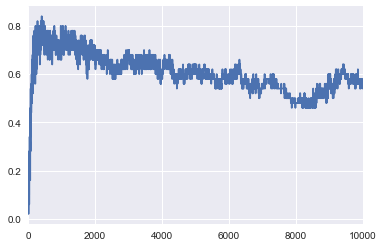

In [18]:
sns.tsplot(data = av_games_opt_share)

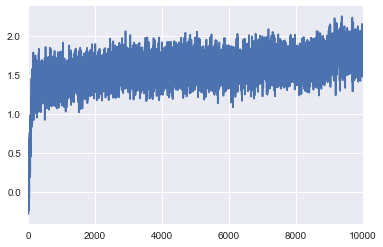

In [19]:
sns.tsplot(data = av_games_reward)

In [23]:
ucb_test = run_n_games(
        N_bandits = 10,
        N_steps = 10 ** 4,
        N_games = 50,
        optim = "UCB",
        epsi = 0.1, #This is for random search
        c = 2, #UCB parameter
        step_size = 0.1 #Used for grad bandit and const greedy thingy
    )

Playing game 40 of 50


In [24]:
game_reward_list= ucb_test[0]
game_action_list = ucb_test[1]
game_optimal_action_list = ucb_test[2]

reward_arr = np.asarray(game_reward_list)

N_steps = len(game_reward_list[0])
N_games = len(game_reward_list)

av_games_opt_share = []
av_games_reward = []
for i in range(N_steps):
    
    if i % 100 == 0:
        clear_output(wait = True)
        print("Measuring step " + str(i) + " of " + str(N_steps))

    
    games_action = np.asarray([a[i] for a in game_action_list])
    games_optimal_action = np.asarray([a[i] for a in game_optimal_action_list])
    games_reward = np.asarray([a[i] for a in game_reward_list])
    
    av_games_reward.append(games_reward.mean())
    av_games_opt_share.append(((games_optimal_action == games_action).sum())/N_games)

Measuring step 9900 of 10000


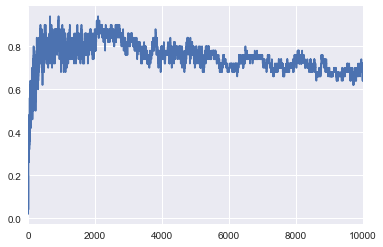

In [25]:
sns.tsplot(data = av_games_opt_share)

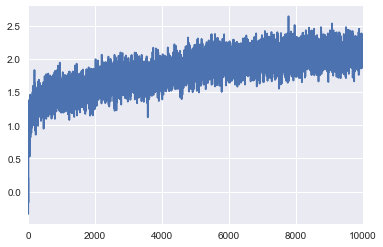

In [26]:
sns.tsplot(data = av_games_reward)

In [21]:
param_vec = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
N_STEPS = 10000 #2 * (10 ** 5)
N_GAMES = 100

In [12]:
print("Doing grad bandit")
grad_bandit_list = []
for i in range(len(param_vec)):            
    param = param_vec[i]
               
    grad_bandit_result = run_n_games(
            N_bandits = 10,
            N_steps = N_STEPS,
            N_games = N_GAMES,
            optim = "grad_bandit",
            epsi = 0.1, #This is for random search
            c = 2, #UCB parameter
            step_size = param,
            pass_print = " param " + str(i) + " of " + str(len(param_vec))#Used for grad bandit and const greedy thingy,
        )
    grad_bandit_list.append(grad_bandit_result)
    
with open('grad_bandit_list', 'wb') as fp:
    pickle.dump(grad_bandit_list, fp)

Playing game 90 of 100 param 9 of 10


In [13]:
del grad_bandit_list

In [14]:
print("Doing ucb")
ucb_list = []
for i in range(len(param_vec)):            
    param = param_vec[i]

    ucb_result = run_n_games(
        N_bandits = 10,
        N_steps = N_STEPS,
        N_games = N_GAMES,
        optim = "UCB",
        epsi = 0.1, #This is for random search
        c = param, #UCB parameter
        step_size = 0.1, #Used for grad bandit and const greedy thingy
        pass_print = " param " + str(i) + " of " + str(len(param_vec))
    )
    
    ucb_list.append(ucb_result)
    
with open('ucb_list', 'wb') as fp:
    pickle.dump(ucb_list, fp)

del ucb_list

Playing game 90 of 100 param 9 of 10


In [16]:
print("Doing random_search_av")
random_search_av_list = []
for i in range(len(param_vec)):            
    param = param_vec[i]

    random_search_av_result = run_n_games(
        N_bandits = 10,
        N_steps = N_STEPS,
        N_games = N_GAMES,
        optim = "random_search_av",
        epsi = 0.1, #This is for random search
        c = 2, #UCB parameter
        step_size = param, #Used for grad bandit and const greedy thingy
        pass_print = " param " + str(i) + " of " + str(len(param_vec))
    )
    
    random_search_av_list.append(random_search_av_result)
    
with open('random_search_av_list', 'wb') as fp:
    pickle.dump(random_search_av_list, fp)
    
del random_search_av_list

Playing game 90 of 100 param 9 of 10


In [17]:
print("Doing random_search_const")
random_search_const_list = []
for i in range(len(param_vec)):            
    param = param_vec[i]

    random_search_const_result = run_n_games(
        N_bandits = 10,
        N_steps = N_STEPS,
        N_games = N_GAMES,
        optim = "random_search_const",
        epsi = 0.1, #This is for random search
        c = 2, #UCB parameter
        step_size = param, #Used for grad bandit and const greedy thingy
        pass_print = " param " + str(i) + " of " + str(len(param_vec))
    )
    
    random_search_const_list.append(random_search_const_result)
    
with open('random_search_const_list', 'wb') as fp:
    pickle.dump(random_search_const_list, fp)

del random_search_const_list

Playing game 90 of 100 param 9 of 10


In [19]:
print("Doing random_search_opt")
random_search_opt_list = []
for i in range(len(param_vec)):            
    param = param_vec[i]

    random_search_opt_result = run_n_games(
        N_bandits = 10,
        N_steps = N_STEPS,
        N_games = N_GAMES,
        optim = "random_search_opt",
        epsi = 0.1, #This is for random search
        c = 2, #UCB parameter
        step_size = 0.1, #Used for grad bandit and const greedy thingy
        init_action_value = param,
        pass_print = " param " + str(i) + " of " + str(len(param_vec))
    )
    
    random_search_opt_list.append(random_search_opt_result)
    
with open('random_search_opt_list', 'wb') as fp:
    pickle.dump(random_search_opt_list, fp)

del random_search_opt_list

Playing game 90 of 100 param 9 of 10


In [23]:
AV_SINCE = 5000
FILES = ["grad_bandit_list", "random_search_av_list", "random_search_const_list", "ucb_list", "random_search_opt_list"]

methods = {k:[] for k in FILES}
for FILE in FILES:
    with open(FILE, mode = "rb") as pickle_file:
        str_list = pickle.load(pickle_file)

    param_rewards = {k:0 for k in param_vec}
    for param_i in range(len(param_vec)):
        reward_game_hist = str_list[param_i][0]
        av_games_reward = []
        for i in range(N_STEPS):

            if i % 100 == 0:
                clear_output(wait = True)
                print("Measuring step " + str(i) + " of " + str(N_STEPS))

            games_reward = np.asarray([a[i] for a in reward_game_hist])

            av_games_reward.append(games_reward.mean())
        param_rewards[param_vec[param_i]] = np.asarray(av_games_reward[AV_SINCE:]).mean()
    
    methods[FILE] = param_rewards

Measuring step 9900 of 10000


In [35]:
sns_df.index

Float64Index([0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0,
              4.0],
             dtype='float64')

In [24]:
import pandas as pd
sns_df = pd.DataFrame.from_dict(methods)
sns_df["param_value"] = sns_df.index

In [25]:
sns_df.head()

grad_bandit_list  random_search_av_list  random_search_const_list  \
0.007812          1.809562               1.684301                  1.671080   
0.015625          1.655687               1.665667                  1.749216   
0.031250          1.711051               1.738719                  1.771310   
0.062500          1.763073               1.825937                  1.859540   
0.125000          1.623317               1.751934                  1.881120   

          random_search_opt_list  ucb_list  param_value  
0.007812                1.567322  1.545894     0.007812  
0.015625                1.769023  1.494860     0.015625  
0.031250                1.721854  1.571954     0.031250  
0.062500                1.462564  1.562183     0.062500  
0.125000                1.717694  1.710892     0.125000

In [26]:
sns_df = sns_df.melt(id_vars = "param_value")

In [27]:
sns_df

param_value                  variable     value
0      0.007812          grad_bandit_list  1.809562
1      0.015625          grad_bandit_list  1.655687
2      0.031250          grad_bandit_list  1.711051
3      0.062500          grad_bandit_list  1.763073
4      0.125000          grad_bandit_list  1.623317
5      0.250000          grad_bandit_list  1.558610
6      0.500000          grad_bandit_list  1.516194
7      1.000000          grad_bandit_list  1.480545
8      2.000000          grad_bandit_list  1.404197
9      4.000000          grad_bandit_list  0.992262
10     0.007812     random_search_av_list  1.684301
11     0.015625     random_search_av_list  1.665667
12     0.031250     random_search_av_list  1.738719
13     0.062500     random_search_av_list  1.825937
14     0.125000     random_search_av_list  1.751934
15     0.250000     random_search_av_list  1.799985
16     0.500000     random_search_av_list  1.756657
17     1.000000     random_search_av_list  1.649391
18     2.000000     random_search_av_list  1.653949
19     4.000000     random_search_av_list  1.680638
20     0.007812  random_search_const_list  1.671080
21     0.015625  random_search_const_list  1.749216
22     0.031250  random_search_const_list  1.771310
23     0.062500  random_search_const_list  1.859540
24     0.125000  random_search_const_list  1.881120
25     0.250000  random_search_const_list  1.676123
26     0.500000  random_search_const_list  1.681525
27     1.000000  random_search_const_list  1.610868
28     2.000000  random_search_const_list  0.038966
29     4.000000  random_search_const_list -0.025037
30     0.007812    random_search_opt_list  1.567322
31     0.015625    random_search_opt_list  1.769023
32     0.031250    random_search_opt_list  1.721854
33     0.062500    random_search_opt_list  1.462564
34     0.125000    random_search_opt_list  1.717694
35     0.250000    random_search_opt_list  1.634265
36     0.500000    random_search_opt_list  1.677797
37     1.000000    random_search_opt_list  1.678461
38     2.000000    random_search_opt_list  1.823917
39     4.000000    random_search_opt_list  1.499897
40     0.007812                  ucb_list  1.545894
41     0.015625                  ucb_list  1.494860
42     0.031250                  ucb_list  1.571954
43     0.062500                  ucb_list  1.562183
44     0.125000                  ucb_list  1.710892
45     0.250000                  ucb_list  1.772324
46     0.500000                  ucb_list  1.826651
47     1.000000                  ucb_list  1.908999
48     2.000000                  ucb_list  1.962214
49     4.000000                  ucb_list  2.024454

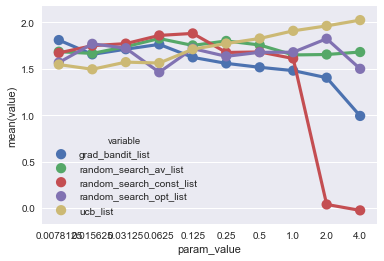

In [28]:
sns.pointplot(x = sns_df["param_value"], y = sns_df["value"], hue = sns_df["variable"])